# Exercise 7

## Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
from torch.utils.data import DataLoader
from scipy.spatial.distance import pdist
from utils import MLP, split_data, Dataset, train, Data

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# check if a GPU is available
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
DEVICE

'mps'

In [3]:
molecule = np.array(
    [
        [0.702581, 1.820873],
        [0.702581, 0.296325],
        [-0.702581, -0.296325],
        [-0.702581, -1.820873],
    ]
)

n_atoms = molecule.shape[0]
n_dimensions = molecule.shape[1]

print(
    f"Number of particles: {n_atoms} \nNumber of spatial dimensions: {n_dimensions}",
)

Number of particles: 4 
Number of spatial dimensions: 2


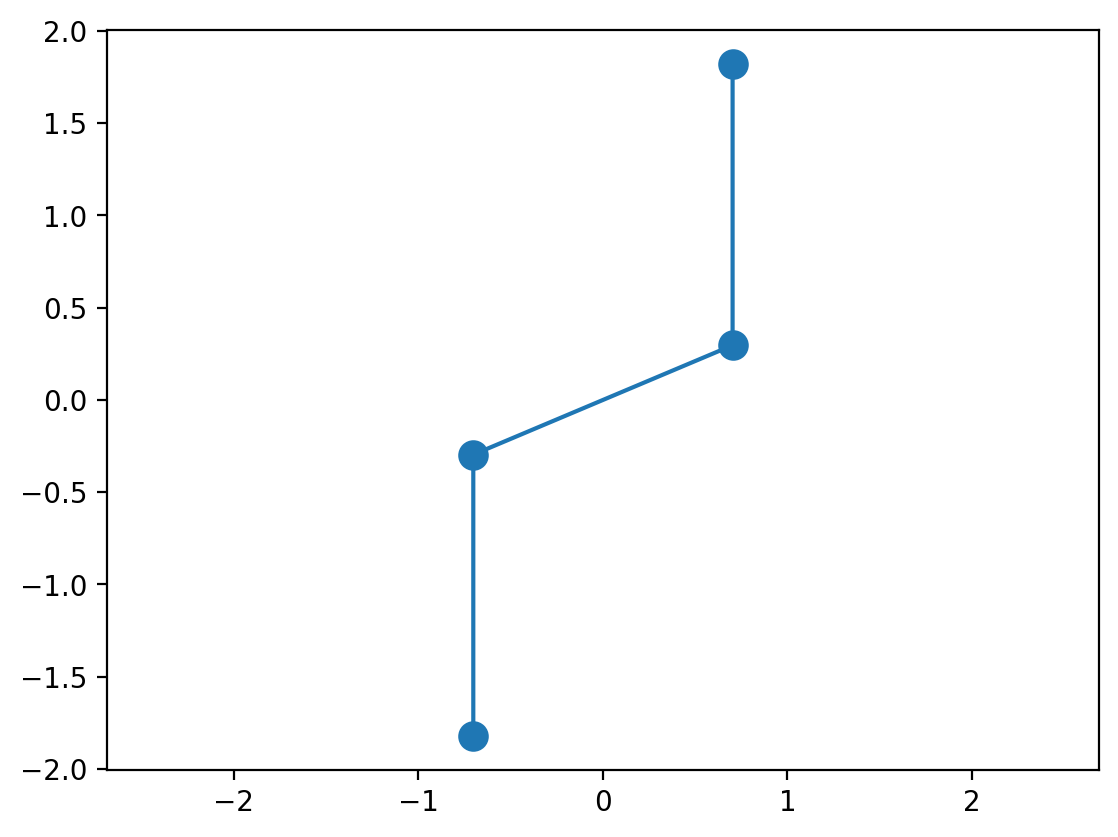

In [4]:
plt.plot(molecule[:, 0], molecule[:, 1], "o-", markersize=10)
plt.axis("equal")
plt.show()

## Data Generation

In [5]:
n_samples = 500
noise = np.random.normal(loc=0.0, scale=0.1, size=(n_samples, n_atoms, n_dimensions))
positions = molecule + noise

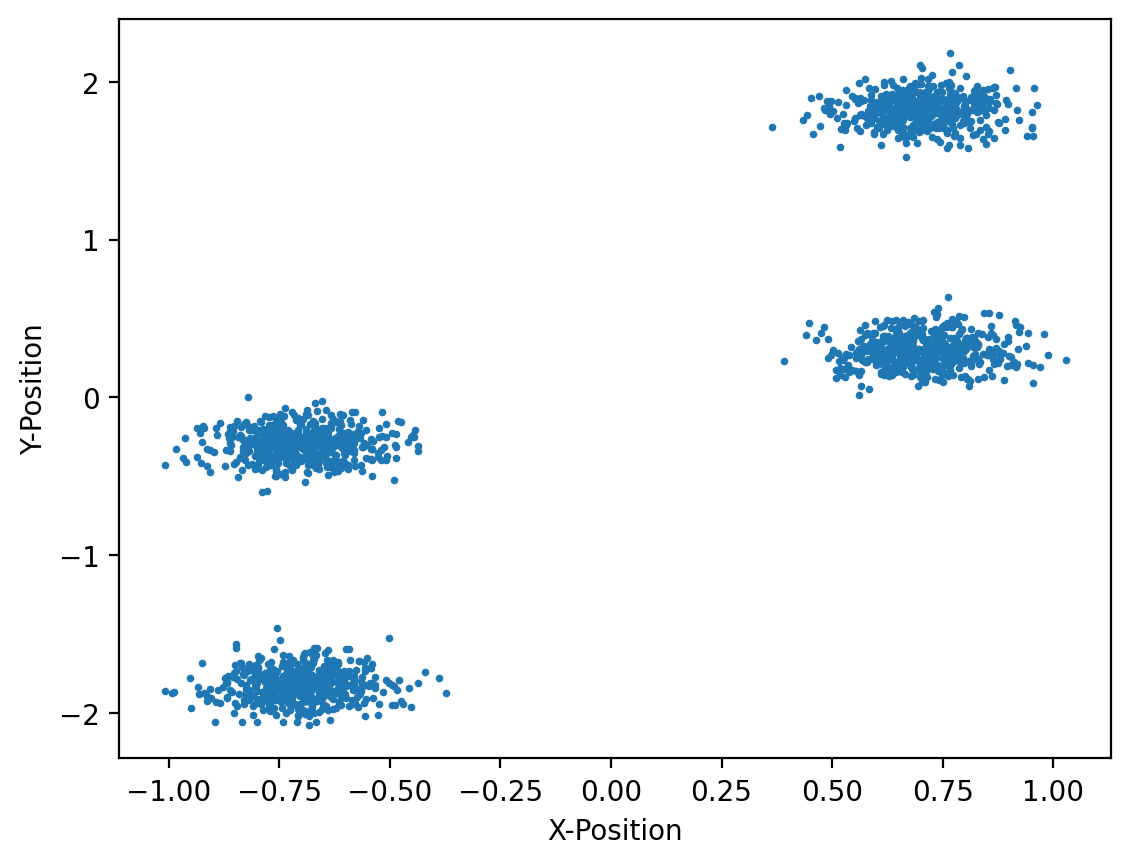

In [19]:
plt.scatter(positions[:, :, 0], positions[:, :, 1], s=3)
plt.xlabel("X-Position")
plt.ylabel("Y-Position")
plt.savefig("positions.png", dpi=300)
plt.show()

## Featurization

### Absolute Atomic Positions

In [7]:
atomic_positions = np.reshape(positions, shape=(n_samples, n_atoms*n_dimensions))

### Pairwise distances

In [20]:
pairwise_distances = np.array([pdist(position) for position in positions])
pair_potential = 1 / pairwise_distances
energies = np.zeros((pair_potential.shape[0], 1))
for sample_index in range(pair_potential.shape[0]):
    for i in range(pair_potential.shape[1]):
        for j in range(i+1, pair_potential.shape[1]):
            energies[sample_index] += pair_potential[sample_index, j]

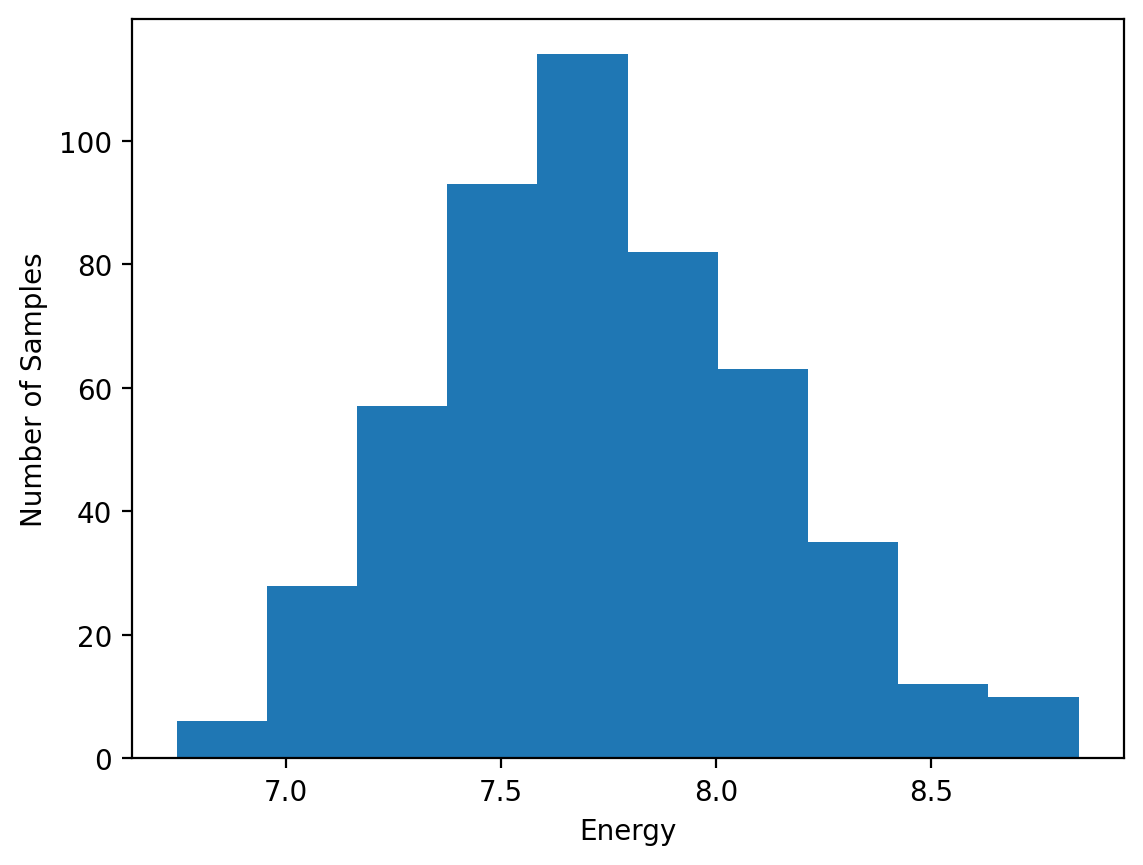

In [21]:
plt.hist(energies, bins=10)
plt.xlabel("Energy")
plt.ylabel("Number of Samples")
plt.savefig("energy_hist.png", dpi=300)
plt.show()

## Datasets and DataLoaders

In [22]:
all_atomic, atomic_train, atomic_test = split_data(atomic_positions, energies, 0.8, DEVICE)
all_pairwise, pairwise_train, pairwise_test = split_data(pairwise_distances, energies, 0.8, DEVICE)
atomic_loader = DataLoader(atomic_train, batch_size=16, shuffle=True)
pairwise_loader = DataLoader(pairwise_train, batch_size=16, shuffle=True)

## Training

In [58]:
EPOCHS = 1000

In [59]:
mlp_atomic = MLP([8, 32, 64, 64, 32, 1]).to(DEVICE)
atomic_optim = torch.optim.Adam(mlp_atomic.parameters())
atomic_loss = torch.nn.MSELoss()
atomic_losses = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    atomic_losses[epoch] = train(mlp_atomic, atomic_loader, atomic_optim, atomic_loss, DEVICE)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {atomic_losses[epoch]}")

Epoch: 0 | Loss: 56.74536209106445
Epoch: 100 | Loss: 0.07836006730794906
Epoch: 200 | Loss: 0.0023243764927610754
Epoch: 300 | Loss: 0.002249772713985294
Epoch: 400 | Loss: 0.0018592801305931063
Epoch: 500 | Loss: 0.0016337626788299532
Epoch: 600 | Loss: 0.0006236589094623924
Epoch: 700 | Loss: 0.0010452500567771493
Epoch: 800 | Loss: 0.0005057778389891609
Epoch: 900 | Loss: 0.00044967204332351684


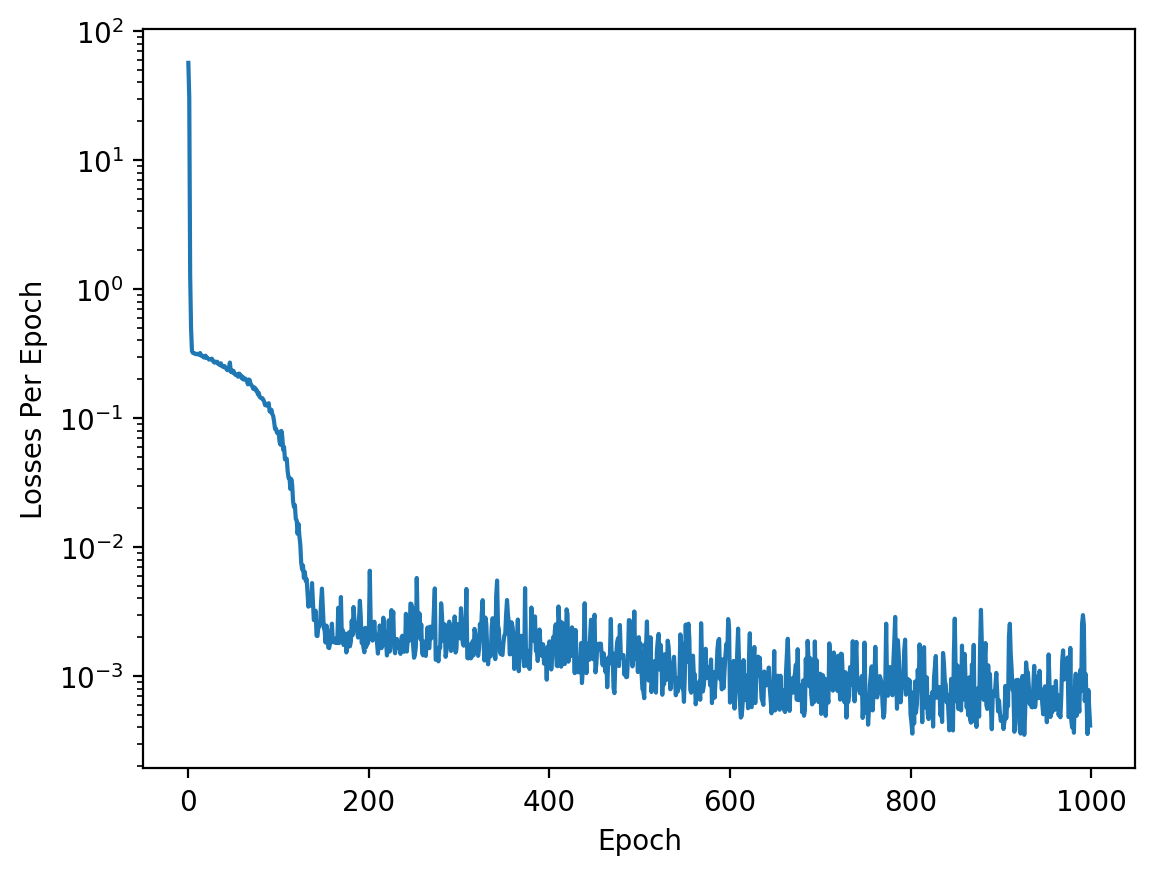

In [60]:
plt.plot(atomic_losses)
plt.xlabel("Epoch")
plt.ylabel("Losses Per Epoch")
plt.yscale('log')
plt.savefig("losses_atomic_positions.png", dpi=300)
plt.show()

In [61]:
mlp_atomic.eval()
atomic_pred = mlp_atomic(atomic_test.x)
atomic_test_error = mean_squared_error(atomic_pred, atomic_test.y).item()
print(f"MSE (Atomic Positions): {atomic_test_error}")

MSE (Atomic Positions): 0.0005504497676156461


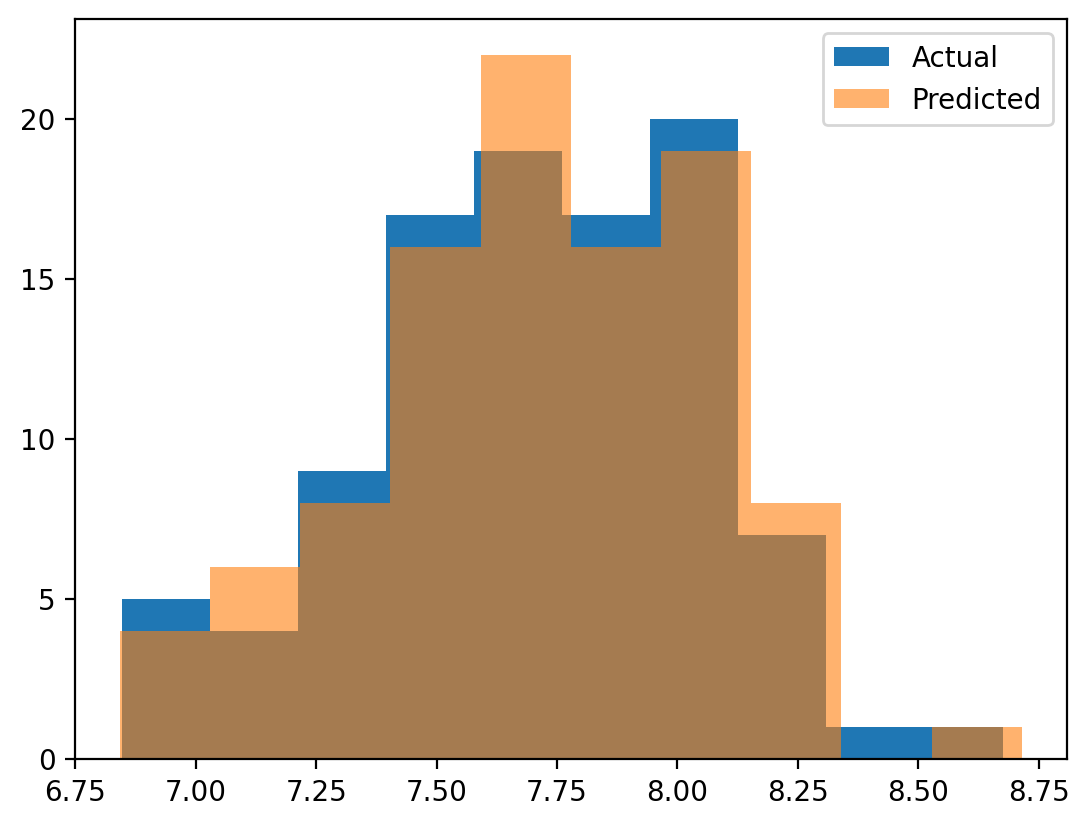

In [106]:
plt.hist(atomic_test.y.cpu().numpy().reshape(100), label="Actual")
plt.hist(atomic_pred.cpu().detach().numpy().reshape(100), alpha=0.6, label="Predicted")
plt.savefig("pred_true_hist_atomic.png")
plt.legend()
plt.show()

In [63]:
mlp_pairwise = MLP([6, 32, 64, 64, 32, 1]).to(DEVICE)
pairwise_optim = torch.optim.Adam(mlp_pairwise.parameters())
pairwise_loss = torch.nn.MSELoss()
pairwise_losses = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    pairwise_losses[epoch] = train(mlp_pairwise, pairwise_loader, pairwise_optim, pairwise_loss, DEVICE)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {pairwise_losses[epoch]}")

Epoch: 0 | Loss: 53.71467239379883
Epoch: 100 | Loss: 0.1638667094707489
Epoch: 200 | Loss: 0.0014879620540887118
Epoch: 300 | Loss: 0.001521433063899167
Epoch: 400 | Loss: 0.0005629112152382731
Epoch: 500 | Loss: 0.0007350213784957305
Epoch: 600 | Loss: 0.0006013074133079499
Epoch: 700 | Loss: 0.0005256547627504915
Epoch: 800 | Loss: 0.0008236608793959022
Epoch: 900 | Loss: 0.0004520568670704961


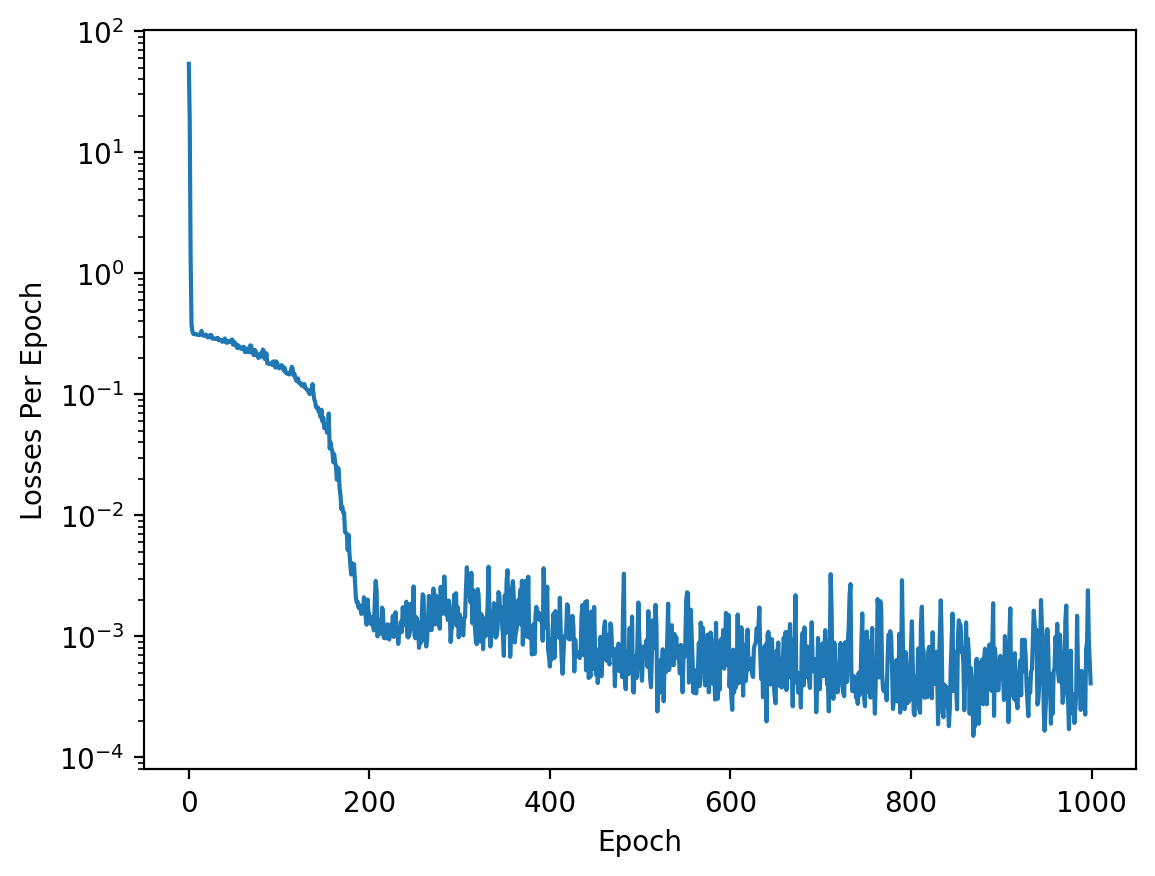

In [64]:
plt.plot(pairwise_losses)
plt.xlabel("Epoch")
plt.ylabel("Losses Per Epoch")
plt.yscale('log')
plt.savefig("losses_pairwise.png", dpi=300)
plt.show()

In [65]:
mlp_pairwise.eval()
pairwise_pred = mlp_pairwise(pairwise_test.x)
pairwise_test_error = mean_squared_error(pairwise_pred, pairwise_test.y).item()
print(f"MSE (Pairwise Distances): {pairwise_test_error}")

MSE (Pairwise Distances): 0.0004821348120458424


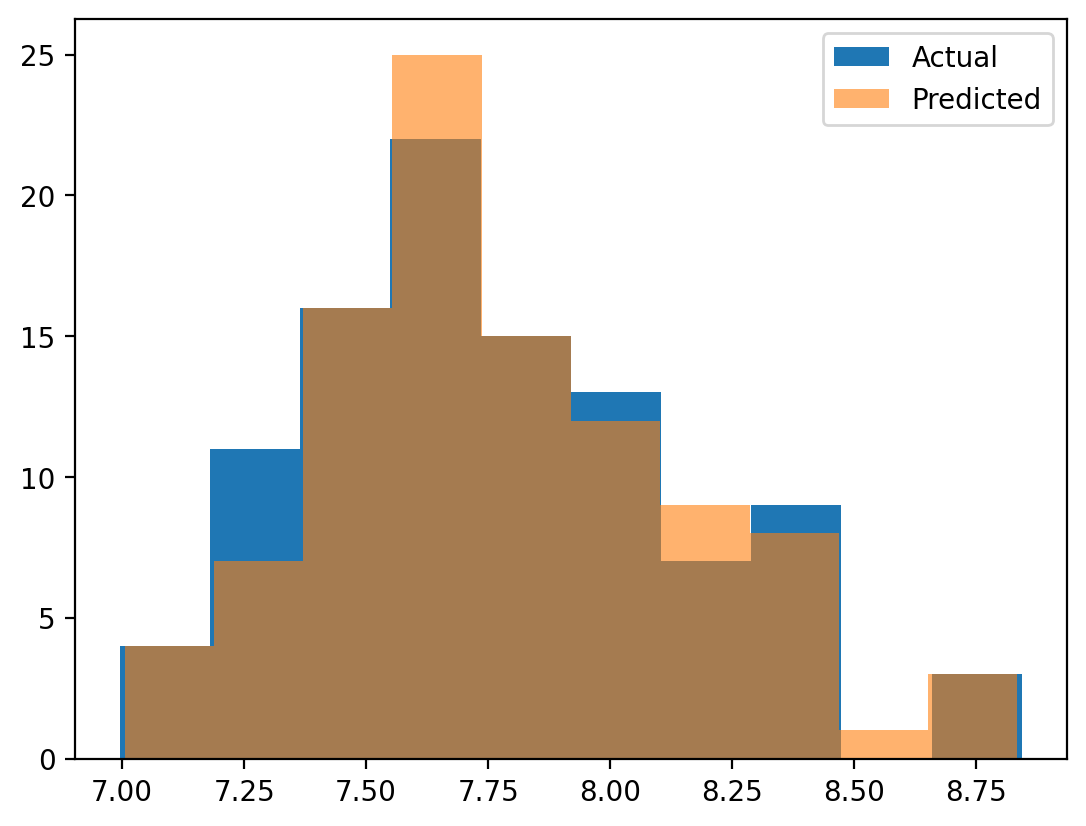

In [104]:
plt.hist(pairwise_test.y.cpu().numpy().reshape(100), label="Actual")
plt.hist(pairwise_pred.cpu().detach().numpy().reshape(100), alpha=0.6, label="Predicted")
plt.savefig("pred_true_hist_pairwise.png")
plt.legend()
plt.show()

## Data Augmentation Functions

In [68]:
def rotate(vector, theta):
    """Rotates a two-dimensional vector by the angle theta."""
    rotMatrix = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    return np.matmul(rotMatrix, vector)

permutation = [3, 0, 1, 2]

## Data Generation Rotated

### Sample Rotated Positions

In [69]:
positions_rotated = np.array([[rotate(position, np.pi/2) for position in molecule] for molecule in positions])

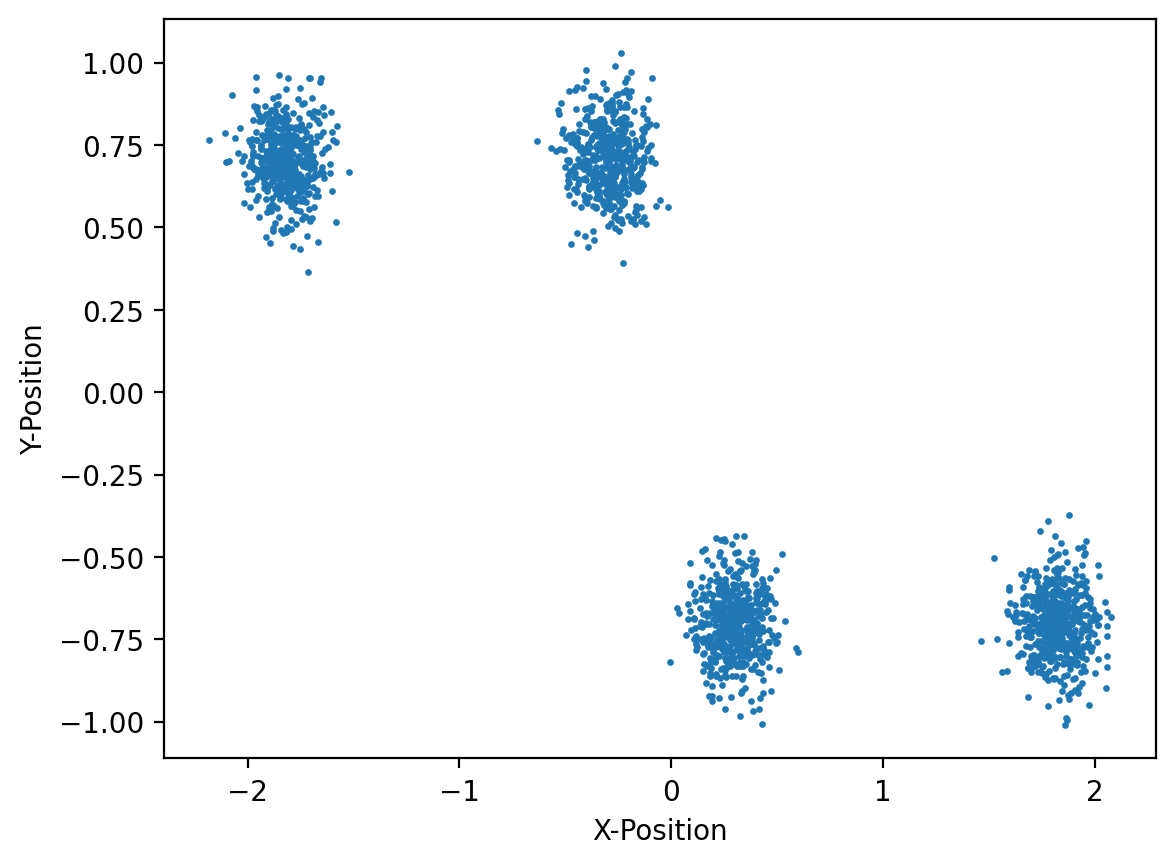

In [71]:
plt.scatter(positions_rotated[:, :, 0], positions_rotated[:, :, 1], s=2)
plt.xlabel("X-Position")
plt.ylabel("Y-Position")
plt.savefig("positions_rotated.png")
plt.show()

### Featurization

In [72]:
atomic_positions_rotated = np.reshape(positions_rotated, shape=(n_samples, n_atoms*n_dimensions))

In [73]:
pairwise_distances_rotated = np.array([pdist(position) for position in positions_rotated])
pair_potential_rotated = 1 / pairwise_distances_rotated
energies_rotated = np.zeros((pair_potential_rotated.shape[0], 1))
for sample_index in range(pair_potential_rotated.shape[0]):
    for i in range(pair_potential_rotated.shape[1]):
        for j in range(i+1, pair_potential_rotated.shape[1]):
            energies_rotated[sample_index] += pair_potential_rotated[sample_index, j]

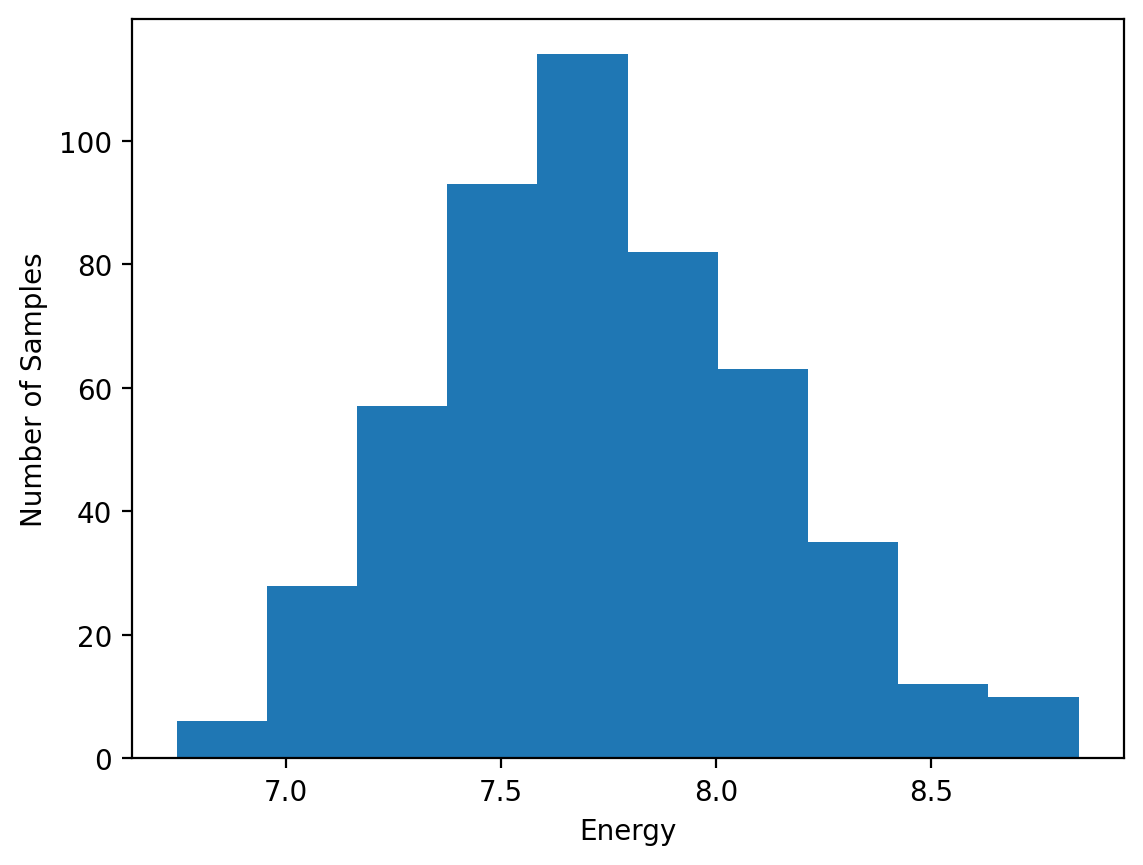

In [74]:
plt.hist(energies_rotated, bins=10)
plt.xlabel("Energy")
plt.ylabel("Number of Samples")
plt.savefig("energy_rotated_hist.png", dpi=300)
plt.show()

### Datasets

In [75]:
all_atomic_rotated, atomic_train_rotated, atomic_test_rotated = split_data(atomic_positions_rotated, energies_rotated, 0.8, DEVICE)
all_pairwise_rotated, pairwise_train_rotated, pairwise_test_rotated = split_data(pairwise_distances_rotated, energies_rotated, 0.8, DEVICE)

### Evaluate MLP

In [94]:
mlp_atomic.eval()
atomic_pred_rotated = mlp_atomic(all_atomic_rotated.x)
atomic_rotated_test_error = mean_squared_error(atomic_pred_rotated, all_atomic_rotated.y).item()
print(f"MSE (Atomic Positions Rotated): {atomic_rotated_test_error}")

MSE (Atomic Positions Rotated): 69.45368194580078


In [95]:
mlp_pairwise.eval()
pairwise_pred_rotated = mlp_pairwise(all_pairwise_rotated.x)
pairwise_rotated_test_error = mean_squared_error(pairwise_pred_rotated, all_pairwise_rotated.y).item()
print(f"MSE (Pairwise Distances Rotated): {pairwise_rotated_test_error}")

MSE (Pairwise Distances Rotated): 0.00045225649955682456


We observe that the rotated positions achieve a much worse MSE on the MLP trained with the atomic positions. However, it acheives a almost equal MSE on the MLP trained with the pairwise distances. The reason for this is obvious. The pairwise distance does not change upon rotation, such that the input is symmetric under rotation. However, the atomic positions are not symmetric under rotation. It follows that the MLP is very bad at predicting the rotated positions.

## Data Generation Permutation

### Sample Permuted Positions

In [80]:
positions_permuted = positions[:, permutation, :]

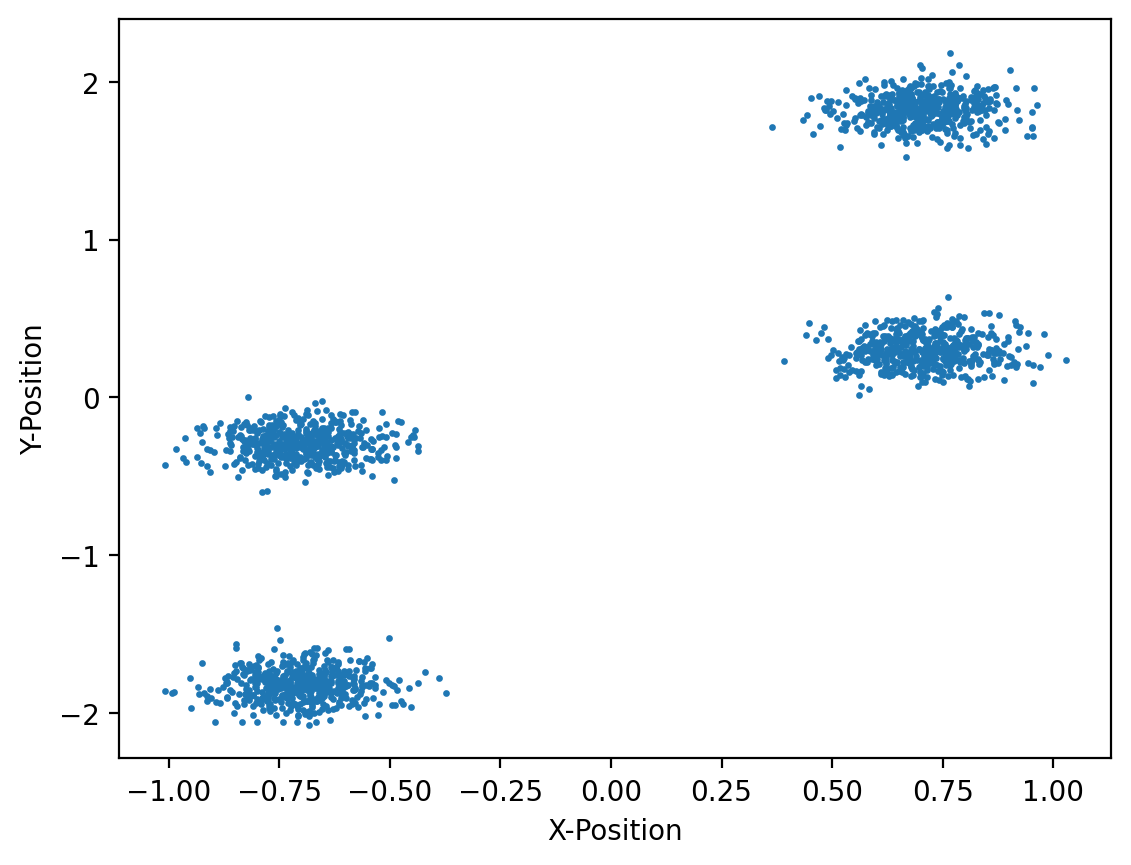

In [82]:
plt.scatter(positions_permuted[:, :, 0], positions_permuted[:, :, 1], s=2)
plt.xlabel("X-Position")
plt.ylabel("Y-Position")
plt.savefig("positions_permuted.png")
plt.show()

### Featurization

In [83]:
atomic_positions_permuted = np.reshape(positions_permuted, shape=(n_samples, n_atoms*n_dimensions))

In [85]:
pairwise_distances_permuted = np.array([pdist(position) for position in positions_permuted])
pair_potential_permuted = 1 / pairwise_distances_permuted
energies_permuted = np.zeros((pair_potential_permuted.shape[0], 1))
for sample_index in range(pair_potential_permuted.shape[0]):
    for i in range(pair_potential_permuted.shape[1]):
        for j in range(i+1, pair_potential_permuted.shape[1]):
            energies_permuted[sample_index] += pair_potential_permuted[sample_index, j]

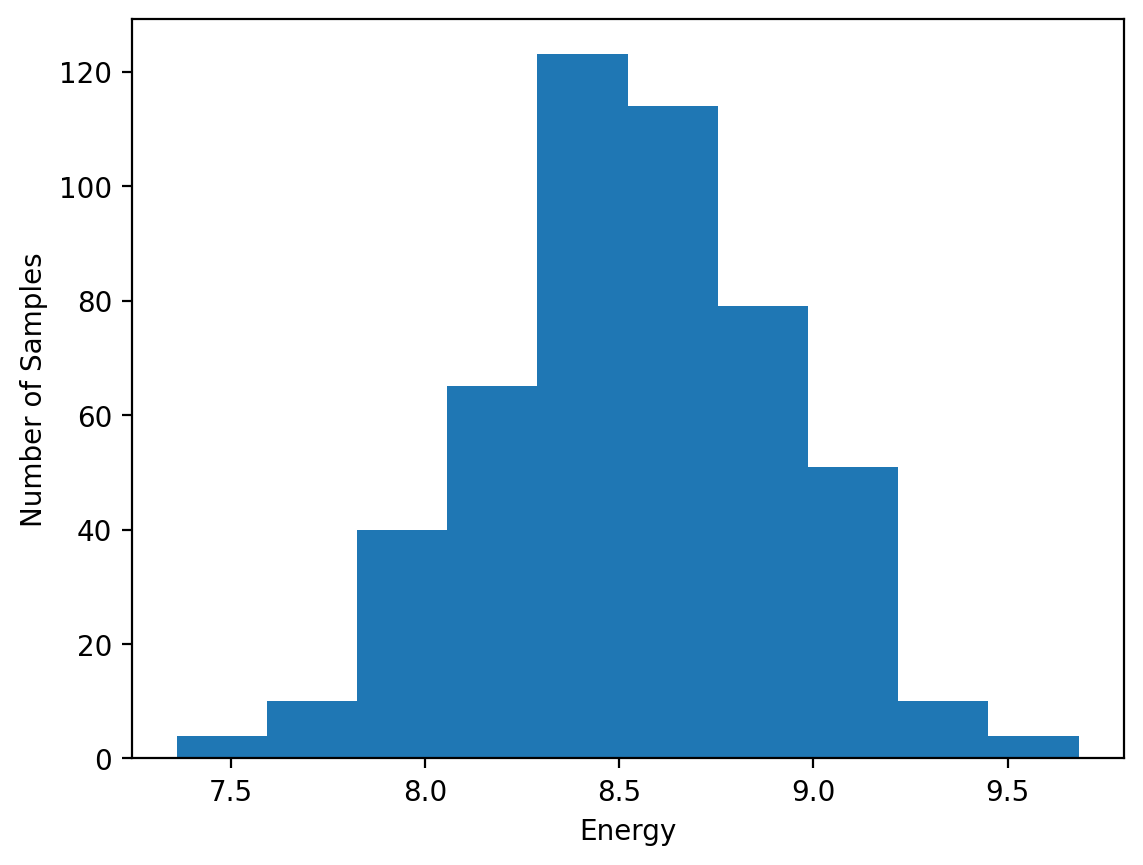

In [87]:
plt.hist(energies_permuted, bins=10)
plt.xlabel("Energy")
plt.ylabel("Number of Samples")
plt.savefig("energy_permuted_hist.png", dpi=300)
plt.show()

### Datasets

In [88]:
all_atomic_permuted, atomic_train_permuted, atomic_test_permuted = split_data(atomic_positions_permuted, energies_permuted, 0.8, DEVICE)
all_pairwise_permuted, pairwise_train_permuted, pairwise_test_permuted = split_data(pairwise_distances_permuted, energies_permuted, 0.8, DEVICE)

### Evaluate MLP

In [96]:
mlp_atomic.eval()
atomic_pred_permuted = mlp_atomic(all_atomic_permuted.x)
atomic_permuted_test_error = mean_squared_error(atomic_pred_permuted, all_atomic_permuted.y).item()
print(f"MSE (Atomic Positions Permuted): {atomic_permuted_test_error}")

MSE (Atomic Positions Permuted): 1.6383295059204102


In [97]:
mlp_pairwise.eval()
pairwise_pred_permuted = mlp_pairwise(all_pairwise_permuted.x)
pairwise_permuted_test_error = mean_squared_error(pairwise_pred_permuted, all_pairwise_permuted.y).item()
print(f"MSE (Pairwise Distances Permuted): {pairwise_permuted_test_error}")

MSE (Pairwise Distances Permuted): 16.059133529663086


We observe that the MSE of the prediction on the atomic positions is much lower than the MSE of the prediction using the pairwise distances. When permuting the positions of the particles within the molecule, we drastically change the pairwise distances for each particle in the molecule. It follows that that the total potential energy is also different. Therefore it makes sense that the MSE is higher for the pairwise featurization. Permuting the atomic position only leads to that the order at which the molecules are inputed to the MLP change. We can see that this impacts the MLP but less than for the pairwise distances.

## Augmented Data

### Data Generation, Featurization, Datasets, DataLoaders

In [122]:
positions_with_rotated = np.vstack((positions, positions_rotated))
atomic_positions_with_rotated = np.reshape(positions_with_rotated, shape=(2*n_samples, n_atoms*n_dimensions))
pairwise_distances_with_rotated = np.array([pdist(position) for position in positions_with_rotated])
pair_potential_with_rotated = 1 / pairwise_distances_with_rotated
energies_with_rotated = np.zeros((pair_potential_with_rotated.shape[0], 1))
for sample_index in range(pair_potential_with_rotated.shape[0]):
    for i in range(pair_potential_with_rotated.shape[1]):
        for j in range(i+1, pair_potential_with_rotated.shape[1]):
            energies_with_rotated[sample_index] += pair_potential_with_rotated[sample_index, j]

_, atomic_train_with_rotated, _ = split_data(atomic_positions_with_rotated, energies_with_rotated, 0.8, DEVICE)
_, pairwise_train_with_rotated, _ = split_data(pairwise_distances_with_rotated, energies_with_rotated, 0.8, DEVICE)
atomic_loader_with_rotated = DataLoader(atomic_train_with_rotated, batch_size=16, shuffle=True)
pairwise_loader_with_rotated = DataLoader(pairwise_train_with_rotated, batch_size=16, shuffle=True)

In [135]:
positions_with_permuted = np.vstack((positions, positions_permuted))
atomic_positions_with_permuted = np.reshape(positions_with_permuted, shape=(2*n_samples, n_atoms*n_dimensions))
pairwise_distances_with_permuted = np.array([pdist(position) for position in positions_with_permuted])
pair_potential_with_permuted = 1 / pairwise_distances_with_permuted
energies_with_permuted = np.zeros((pair_potential_with_permuted.shape[0], 1))
for sample_index in range(pair_potential_with_permuted.shape[0]):
    for i in range(pair_potential_with_permuted.shape[1]):
        for j in range(i+1, pair_potential_with_permuted.shape[1]):
            energies_with_permuted[sample_index] += pair_potential_with_permuted[sample_index, j]

_, atomic_train_with_permuted, _ = split_data(atomic_positions_with_permuted, energies_with_permuted, 0.8, DEVICE)
_, pairwise_train_with_permuted, _ = split_data(pairwise_distances_with_permuted, energies_with_permuted, 0.8, DEVICE)
atomic_loader_with_permuted = DataLoader(atomic_train_with_permuted, batch_size=16, shuffle=True)
pairwise_loader_with_permuted = DataLoader(pairwise_train_with_permuted, batch_size=16, shuffle=True)

### Training Models

#### Positions With Rotated Positions

In [126]:
mlp_atomic_with_rotated = MLP([8, 32, 64, 64, 32, 1]).to(DEVICE)
atomic_optim_with_rotated = torch.optim.Adam(mlp_atomic_with_rotated.parameters())
atomic_loss_with_rotated = torch.nn.MSELoss()
atomic_losses_with_rotated = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    atomic_losses_with_rotated[epoch] = train(mlp_atomic_with_rotated, atomic_loader_with_rotated, atomic_optim_with_rotated, atomic_loss_with_rotated, DEVICE)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {atomic_losses_with_rotated[epoch]}")

Epoch: 0 | Loss: 42.46162011384964
Epoch: 100 | Loss: 0.0031649243261199444
Epoch: 200 | Loss: 0.003939385748235508
Epoch: 300 | Loss: 0.0021616150869522245
Epoch: 400 | Loss: 0.00220527273893822
Epoch: 500 | Loss: 0.0009186669744667597
Epoch: 600 | Loss: 0.0017897670378442853
Epoch: 700 | Loss: 0.0011565486411564052
Epoch: 800 | Loss: 0.002461815614369698
Epoch: 900 | Loss: 0.0018914986593881623


In [124]:
mlp_pairwise_with_rotated = MLP([6, 32, 64, 64, 32, 1]).to(DEVICE)
pairwise_optim_with_rotated = torch.optim.Adam(mlp_pairwise_with_rotated.parameters())
pairwise_loss_with_rotated = torch.nn.MSELoss()
pairwise_losses_with_rotated = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    pairwise_losses_with_rotated[epoch] = train(mlp_pairwise_with_rotated, pairwise_loader_with_rotated, pairwise_optim_with_rotated, pairwise_loss_with_rotated, DEVICE)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {pairwise_losses_with_rotated[epoch]}")

Epoch: 0 | Loss: 25.735459961891173
Epoch: 100 | Loss: 0.0030382986646145583
Epoch: 200 | Loss: 0.0016203991923248394
Epoch: 300 | Loss: 0.0007923795429815073
Epoch: 400 | Loss: 0.0011352481070207431
Epoch: 500 | Loss: 0.0012256011432327796
Epoch: 600 | Loss: 0.0003143320461094845
Epoch: 700 | Loss: 0.0002915328219751245
Epoch: 800 | Loss: 0.0006099287447432289
Epoch: 900 | Loss: 0.0002963727799215121


##### Eval with Permuted Test Set

In [153]:
mlp_atomic_with_rotated.eval()
pred = mlp_atomic_with_rotated(atomic_test_permuted.x)
test_error = mean_squared_error(pred, atomic_test_permuted.y).item()
print(f"MSE (Atomic Positions Permuted): {test_error}")

MSE (Atomic Positions Permuted): 21.486312866210938


In [154]:
mlp_pairwise_with_rotated.eval()
pred = mlp_pairwise_with_rotated(pairwise_test_permuted.x)
test_error = mean_squared_error(pred, pairwise_test_permuted.y).item()
print(f"MSE (Pairwise Distances Permuted): {test_error}")

MSE (Pairwise Distances Permuted): 0.3158797323703766


The MSE using the atomic positions is when training the mlp with the rotated positions compared to without, which is a suprising result. Also suprisingly we observe that the mlp performs better using the pairwise distances, which contradictory to the earlier result when we found out that when permuting the positions the mlp is worse when using the pairwise distances compared to the atomic positions. The reason why we see this result is not obvious.

##### Eval with Rotated Test Set

In [155]:
mlp_atomic_with_rotated.eval()
pred = mlp_atomic_with_rotated(atomic_test_rotated.x)
test_error = mean_squared_error(pred, atomic_test_rotated.y).item()
print(f"MSE (Atomic Positions Rotated): {test_error}")

MSE (Atomic Positions Rotated): 0.0003989145625382662


In [156]:
mlp_pairwise_with_rotated.eval()
pred = mlp_pairwise_with_rotated(pairwise_test_rotated.x)
test_error = mean_squared_error(pred, pairwise_test_rotated.y).item()
print(f"MSE (Pairwise Distances Rotated): {test_error}")

MSE (Pairwise Distances Rotated): 0.0035929500591009855


As expected the MSE on the test set of the rotated atomic positions and pairwise distances is very low. This makes sense since we have now included the rotated atomic positions and pairwise distances in the training of the mlp. This would lead to the fact that the MLP is better at generalizations under rotation. We observe that the pairwise distances predictions are worse than the atomic position predictions. This could be a sign of overfitting the data to the training data set, since the pairwise distances do not change under rotation. However, the result is a bit suprising and should be further studied.

#### Training With Permuted Positions

In [136]:
mlp_atomic_with_permuted = MLP([8, 32, 64, 64, 32, 1]).to(DEVICE)
atomic_optim_with_permuted = torch.optim.Adam(mlp_atomic_with_permuted.parameters())
atomic_loss_with_permuted = torch.nn.MSELoss()
atomic_losses_with_permuted = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    atomic_losses_with_permuted[epoch] = train(mlp_atomic_with_permuted, atomic_loader_with_permuted, atomic_optim_with_permuted, atomic_loss_with_permuted, DEVICE)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {atomic_losses_with_permuted[epoch]}")

Epoch: 0 | Loss: 49.535734481811524
Epoch: 100 | Loss: 0.00548030311241746
Epoch: 200 | Loss: 0.005338253800291568
Epoch: 300 | Loss: 0.002287224089959636
Epoch: 400 | Loss: 0.0024638579483143986
Epoch: 500 | Loss: 0.0016693110280903056
Epoch: 600 | Loss: 0.001027780418517068
Epoch: 700 | Loss: 0.0009659571564407088
Epoch: 800 | Loss: 0.000556491153256502
Epoch: 900 | Loss: 0.0012103352998383344


In [137]:
mlp_pairwise_with_permuted = MLP([6, 32, 64, 64, 32, 1]).to(DEVICE)
pairwise_optim_with_permuted = torch.optim.Adam(mlp_pairwise_with_permuted.parameters())
pairwise_loss_with_permuted = torch.nn.MSELoss()
pairwise_losses_with_permuted = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    pairwise_losses_with_permuted[epoch] = train(mlp_pairwise_with_permuted, pairwise_loader_with_permuted, pairwise_optim_with_permuted, pairwise_loss_with_permuted, DEVICE)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {pairwise_losses_with_permuted[epoch]}")

Epoch: 0 | Loss: 49.902242031097416
Epoch: 100 | Loss: 0.005903294957242906
Epoch: 200 | Loss: 0.002973068130668253
Epoch: 300 | Loss: 0.0019086157740093768
Epoch: 400 | Loss: 0.0015524494028068148
Epoch: 500 | Loss: 0.0009156292155967094
Epoch: 600 | Loss: 0.0006608090367808472
Epoch: 700 | Loss: 0.0034666674546315335
Epoch: 800 | Loss: 0.0023387525948055554
Epoch: 900 | Loss: 0.0009064808212860953


##### Eval with Permuted Test Set

In [140]:
mlp_atomic_with_permuted.eval()
pred = mlp_atomic_with_permuted(atomic_test_permuted.x)
test_error = mean_squared_error(pred, atomic_test_permuted.y).item()
print(f"MSE (Atomic Positions Permuted): {test_error}")

MSE (Atomic Positions Permuted): 0.000513980514369905


In [157]:
mlp_pairwise_with_permuted.eval()
pred = mlp_pairwise_with_permuted(pairwise_test_permuted.x)
test_error = mean_squared_error(pred, pairwise_test_permuted.y).item()
print(f"MSE (Pairwise Distances Permuted): {test_error}")

MSE (Pairwise Distances Permuted): 0.00037032883847132325


We clearly observe very low MSE for the MLP trained with the permuted positions within the molecule, for both pairwise distances and atomic position. This is an expected result since we include the permuted positions in the training dataset of the MLP it seems obvious that the MLP becomes better at predicting the ouput upon permuting the input data.

##### Eval with Rotated Test Set

In [151]:
mlp_atomic_with_permuted.eval()
pred = mlp_atomic_with_permuted(atomic_test_rotated.x)
test_error = mean_squared_error(pred, atomic_test_rotated.y).item()
print(f"MSE (Atomic Positions Rotated): {test_error}")

MSE (Atomic Positions Rotated): 59.23957824707031


In [152]:
mlp_pairwise_with_permuted.eval()
pred = mlp_pairwise_with_permuted(pairwise_test_rotated.x)
test_error = mean_squared_error(pred, pairwise_test_rotated.y).item()
print(f"MSE (Pairwise Distances Rotated): {test_error}")

MSE (Pairwise Distances Rotated): 0.0003859588468912989


The MLP with permuted positions within the molecule is unable to predict the correct output from the rotated atomic positions. The permutation only changes the ordering of the atomic positions within each molecule and does not shift the atomic position, as a whole. Therefore, it is unable to predict the output based on the rotated atomic positions. However, we observe that the MLP predicts the outputs for the rotated pairwise distances correctly. Since the pairwise distances do not change under rotation the MLP which is still trained on the pairwise distances from the original positions is able to predict the correct output. This makes sense since the statistics of the input data closely resembles the statistic of the data that was used to train the model.

I think data augmentations are very useful techniques to treat invariances with respect to rotations and permutation. We clearly observe that the data augmentations greatly boosts the performance of the MLP for the specific invariance it was trined on. However, it is not feasbile to consider all permutations or rotations. In the real-world consider a few permutations maybe enough for the model to be able to generalise the invariance with respect to permutation. If you have 1024 and wanted to include all permutations, your dataset would be 1024! large, which is not feasible. Even better would be if the invariances to rotations and permtuations were encoded in the data featurization.